# Customer Segmentation with RFM Analysis ad Clustering
This project fokusses on analyszing customer behavior using the RFM (Recency, Frequency, Monetary) framework and clustering techniques.  
The goal ist to segment customers based on their purchasing behaviour to provide actionable insights for targeted marketing strategies. 

## Objectives:

1. Calculate RFM Metrics for each customer.
2. Apply clustering algorithms to segment customer in meaningful groups.
3. Visualize and interpret the clusters to derive buisness insights.

## Data Import and Libraries
We use the **Online Retail II** dataset, which contains transactional daa of a UK-based online retailer.
- Load the dataset using 'pandas'.
- Inspect the structure of the data.

In [75]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import colormaps

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [77]:
# Load the dataset
filepath = r"./online_retail_II.csv"
df = pd.read_csv(filepath)

In [78]:
# Display first few rows
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Data Cleaning and Preparation 
- Removed rows with missing CustomerID.
- Filtered out transactions with negative quantities (cancellations).
- Created a new column 'TotalPrice' to represent the revenue per transaction.
- Converted 'InvoiceDate' to a datetime format for better manipulation.

In [80]:
# Check for missing values
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [84]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['Customer ID'])

In [86]:
# Filter out cancellations (negative quantities)
df = df[df['Quantity'] > 0]

In [88]:
# Create new column for total price
df['TotalPrice'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [90]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

## RFM Analytics
### Definitons: 
- **Recency (R):** How many days since the customer's last purchase.
- **Frequency (F):** How many purchases the customer has made. 
- **Monetary (M):** Total amount spent by the customer.

The RFM metrics are calculated for each customer as shown below: 

In [93]:
# Set the reference date for Recency calculation
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [95]:
# Calculate RFM Metrics
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate' : lambda x: (reference_date - x.max()).days, # Recency
    'Invoice' : 'count', # Frequency
    'TotalPrice' : 'sum' # Monetary
}).rename(columns={
    'InvoiceDate' : 'Recency',
    'Invoice' : 'Frequency',
    'TotalPrice' : 'Monetary'
})

rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,34,77556.46
12347.0,2,253,5633.32
12348.0,75,51,2019.40
12349.0,19,175,4428.69
12350.0,310,17,334.40


### Calculate RFM - Scorings

In [97]:
# Define scoring function
def rfm_score(value, quantiles, reverse=False):
    if reverse:
        if value <= quantiles[0.25]:
            return 4
        elif value <= quantiles[0.50]:
            return 3
        elif value <= quantiles[0.75]:
            return 2
        else:
            return 1
    else:
        if value <= quantiles[0.25]:
            return 1
        elif value <= quantiles[0.50]:
            return 2
        elif value <= quantiles[0.75]:
            return 3
        else:
            return 4

In [99]:
# Calculate quartiles
quantiles = rfm.quantile([0.25, 0.50, 0.75])

In [101]:
# Apply scoring
rfm['R_Score'] = rfm['Recency'].apply(rfm_score, args=(quantiles['Recency'], True))
rfm['F_Score'] = rfm['Frequency'].apply(rfm_score, args=(quantiles['Frequency'], False))
rfm['M_Score'] = rfm['Monetary'].apply(rfm_score, args=(quantiles['Monetary'], False))


In [103]:
# Combine scores into a single RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [105]:
# Display the RFM table with scores
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
12346.0,326,34,77556.46,2,2,4,224
12347.0,2,253,5633.32,4,4,4,444
12348.0,75,51,2019.40,3,2,3,323
12349.0,19,175,4428.69,4,4,4,444
12350.0,310,17,334.40,2,1,1,211


### Clustering via KMeans

To segment customers based on their RFM scores, we use the KMeans clustering algorithm.  
This method groups customers into clusters with similar purchasing behavior. The process involves the following steps:

1. **Determining Optimal Clusters:** The Elbow Method is used to identify the ideal number of clusters by analyzing the Sum of Squared Errors (SSE).
2. **Clustering:** KMeans is applied to create customer segments based on their RFM behavior.

This approach allows us to identify meaningful customer groups, enabling targeted marketing strategies and actionable insights.

In [108]:
# Prepare data for clustering
rfm_clustering = rfm[['R_Score', 'F_Score', 'M_Score']]

In [110]:
# Determine optimal number of clusters using the Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, random_state=42)
    kmeans.fit(rfm_clustering)
    sse.append(kmeans.inertia_)

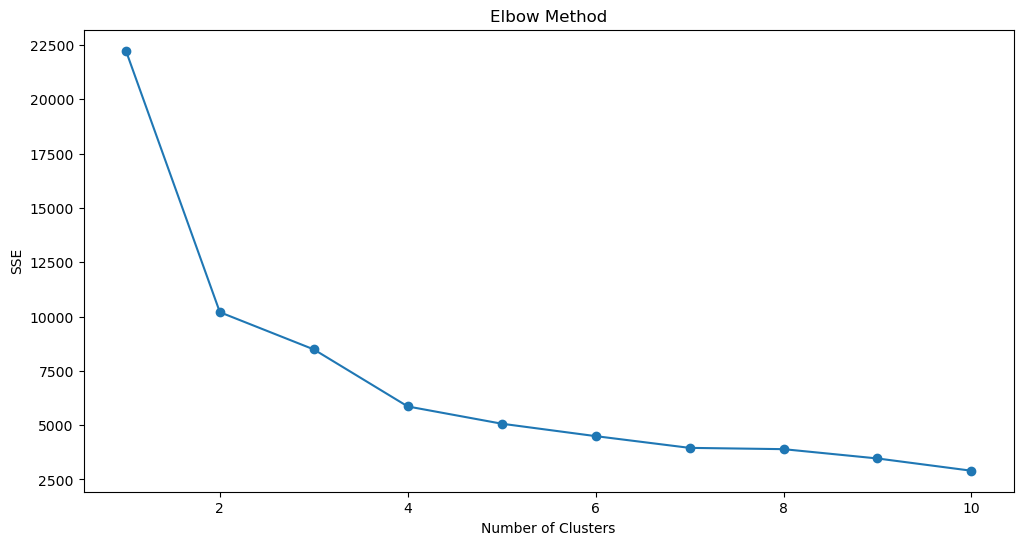

In [112]:
# Plot SSE to fins the elbow
plt.figure(figsize=(12, 6))
plt.plot(range(1 ,11), sse, marker= 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [116]:
# Apply K-Means with optimal clusters 
optimal_clusters =  4

kmeans = KMeans(n_clusters = optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_clustering)

## Visualization

After clustering the customers based on their RFM metrics, we now explore the clusters visually to gain deeper insights.  
The visualizations help us understand the distribution and characteristics of each cluster, providing actionable insights.

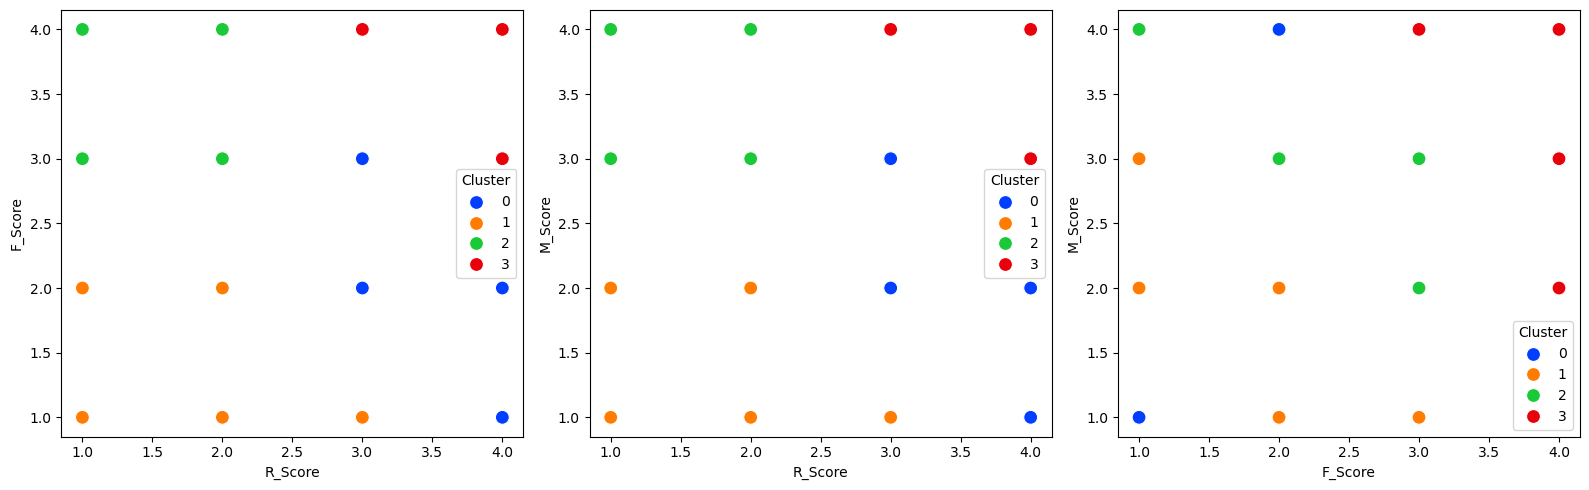

In [131]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

sns.scatterplot(data=rfm, x='R_Score', y='F_Score', hue='Cluster', palette='bright', s=100, ax=axs[0])
sns.scatterplot(data=rfm, x='R_Score', y='M_Score', hue='Cluster', palette='bright', s=100, ax=axs[1])
sns.scatterplot(data=rfm, x='F_Score', y='M_Score', hue='Cluster', palette='bright', s=100, ax=axs[2])

plt.tight_layout()
plt.show() 

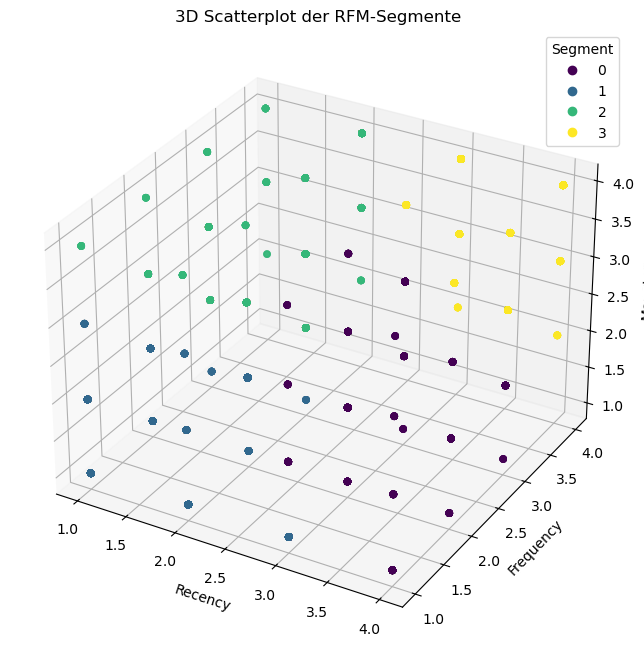

In [129]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

cmap = colormaps['viridis']

scatter = ax.scatter(rfm['R_Score'], rfm['F_Score'], rfm['M_Score'], c=rfm['Cluster'], cmap=cmap)
plt.legend(*scatter.legend_elements(), title="Segment")


ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Scatterplot der RFM-Segmente')

plt.show()

## Customer Segment Analysis and Conclusion

In this section, we analyze the characteristics of the identified customer segments 
and draw actionable conclusions based on the findings.

In [149]:
# Analyze the segments
segment_analysis = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
}).reset_index()

# Rename columns for readability
segment_analysis.columns = [
    'Cluster', 'Recency_Mean', 'Recency_Median', 
    'Frequency_Mean', 'Frequency_Median', 
    'Monetary_Mean', 'Monetary_Median', 'Customer_Count'
]

# Display the analysis results
segment_analysis.round(0)

,Cluster,Recency_Mean,Recency_Median,Frequency_Mean,Frequency_Median,Monetary_Mean,Monetary_Median,Customer_Count
0,0,41.0,38.0,50.0,42.0,1110.0,722.0,1190
1,1,385.0,396.0,20.0,16.0,342.0,281.0,2019
2,2,298.0,277.0,127.0,86.0,2531.0,1405.0,1065
3,3,25.0,18.0,355.0,224.0,8112.0,3602.0,1607


### Segment Analysis

The table above provides a summary of each customer segment based on the following metrics:

- **Recency**: The average and median number of days since the last purchase.
- **Frequency**: The average and median number of purchases.
- **Monetary**: The average and median total spending, along with the total number of customers in each segment.

From these metrics, we can derive the key characteristics of each segment and 
identify potential marketing strategies.

## Conclusion

Based on the analysis of the clusters, the following insights and recommendations can be derived:

- **Cluster 0 (Moderate Customers):**
  - **Characteristics:** These customers have moderately frequent purchases (mean: 38) and a decent monetary value (mean: 1110), but their recency is higher than ideal (mean: 41 days).
  - **Recommendations:** Engage these customers with occasional promotional offers or personalized recommendations to increase their purchase frequency and loyalty.
    
    

- **Cluster 1 (Dormant Customers):**
  - **Characteristics:** Customers in this group have the least recent purchases (mean: 385 days) and lower frequency (mean: 20). Their spending is also on the lower side (mean: 342).
  - **Recommendations:** Focus on re-engagement campaigns, such as win-back strategies or special discounts, to reactivate their interest. Use targeted email campaigns to remind them of new products or seasonal offers.

- **Cluster 2 (High-Potential Customers):**
  - **Characteristics:** These customers have high purchase frequency (mean: 127) and significant monetary value (mean: 2531), but their recency is not as strong as Cluster 3 (mean: 298 days).
  - **Recommendations:** Strengthen the relationship by offering loyalty rewards or personalized campaigns to keep them engaged and move them towards the "High-Value Customers" cluster.

- **Cluster 3 (High-Value Customers):**
  - **Characteristics:** These are the most valuable customers with extremely frequent purchases (mean: 355), very recent transactions (mean: 25 days), and the highest monetary value (mean: 8112).
  - **Recommendations:** Prioritize this group with VIP-level programs, early access to new products, or exclusive offers. Maintain their loyalty through continuous engagement and personalized experiences.

### Next Steps:

1. **Targeted Marketing Campaigns:**
   - Design specific campaigns for each cluster, focusing on reactivation for dormant customers and retention for high-value customers.

2. **Performance Tracking:**
   - Monitor the effectiveness of these campaigns and analyze the response rates for each cluster to refine strategies further.

3. **Continuous Improvement:**
   - Reassess the clusters periodically and adapt to changing customer behaviors by recalibrating the RFM model or clustering technique.